In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from scipy.ndimage import binary_dilation

In [2]:
NUM_TRAIN_SAMPLES = 11647

In [3]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = (512, 384)  # the generated image resolution
    train_batch_size = 4
    eval_batch_size = 4  # how many images to sample during evaluation
    num_epochs = 20
    gradient_accumulation_steps = 1
    learning_rate = 1e-3
    lr_warmup_steps = 500
    save_image_epochs = 5
    save_model_epochs = 1
    mixed_precision = "no"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "mask_checkpoint"  # the model name locally and on the HF Hub
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    # device = "cpu"
    num_steps=None
    num_samples=int(0.9*NUM_TRAIN_SAMPLES)

#     push_to_hub = True  # whether to upload the saved model to the HF Hub
#     hub_model_id = "<your-username>/<my-awesome-model>"  # the name of the repository to create on the HF Hub
#     hub_private_repo = False
#     overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

In [4]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

class FlexibleNormalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        num_channels = tensor.shape[-1]  # Get the number of channels
        adjusted_mean = self.mean[:num_channels]
        adjusted_std = self.std[:num_channels]
        return transforms.functional.normalize(tensor, mean=adjusted_mean, std=adjusted_std)

class VTONHDDataset(Dataset):
    def __init__(self, annotations_file, img_dir, sub_dir, sample_range=None, transform=None):
        """
        :param annotations_file: Đường dẫn đến file chứa các cặp ảnh
        :param img_dir: Thư mục chứa ảnh
        :param transform: Các phép biến đổi cho ảnh
        :param feature_extractor: Mô hình trích xuất đặc trưng cho trang phục
        """
        print(sample_range)
        with open(annotations_file, 'r') as f:
            self.image_pairs = [line.strip().split() for line in f.readlines()][sample_range]
        self.img_dir = img_dir
        self.sub_dir = sub_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        person_path, clothing_path = self.image_pairs[idx]
        
        #target
        parse_v3_mask_image = Image.open(f"{self.sub_dir}/image_parse_v3_binary2/{clothing_path}").convert("L")
        # parse_v3_mask_image = np.expand_dims(parse_v3_mask_image, axis=-1)
        #input
        clothing_mask_image = Image.open(f"{self.img_dir}/cloth-mask/{clothing_path}").convert("RGB")
        # clothing_mask_image = np.expand_dims(clothing_mask_image, axis=-1)
        
        agnostic_mask_image = Image.open(f"{self.sub_dir}/agnostic_mask_binary/{clothing_path}").convert("RGB")
        # agnostic_mask_image = np.expand_dims(agnostic_mask_image, axis=-1)
        
        pose_image = Image.open(f"{self.img_dir}/openpose_img/{clothing_path.replace('.jpg', '_rendered.png')}").convert("RGB")
        
        if self.transform:
            # parse_v3_mask_image = self.transform(parse_v3_mask_image)
            clothing_mask_image = self.transform(clothing_mask_image)
            agnostic_mask_image = self.transform(agnostic_mask_image)
            pose_image = self.transform(pose_image)
            
        transform = transforms.Grayscale(num_output_channels=1)
            
        parse_v3_mask_image = transforms.ToTensor()(transforms.Resize(config.image_size)(parse_v3_mask_image))
        clothing_mask_image = transform(clothing_mask_image)
        agnostic_mask_image = transform(agnostic_mask_image)

        return parse_v3_mask_image, clothing_mask_image, agnostic_mask_image, pose_image

# Biến đổi cho ảnh và trích xuất đặc trưng trang phục
transform = transforms.Compose([
    transforms.Resize(config.image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Tạo DataLoader
DATASET_DIR = "../datasets/viton-hd"
SUB_DIR = "./mask_train_dataset"
dataset = VTONHDDataset(annotations_file=os.path.join(".", 'VITONHD_train_paired.txt'), 
                        img_dir=os.path.join(DATASET_DIR, 'train'), 
                        sub_dir=SUB_DIR,
                        sample_range=slice(config.num_samples),
                        transform=transform)
dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

slice(None, 10482, None)


In [6]:
dataset = VTONHDDataset(annotations_file=os.path.join(".", 'VITONHD_train_paired.txt'), 
                        img_dir=os.path.join(DATASET_DIR, 'train'), 
                        sub_dir=SUB_DIR,
                        sample_range=slice(config.num_samples, NUM_TRAIN_SAMPLES),
                        transform=transform)
val_dataloader = DataLoader(dataset, batch_size=config.eval_batch_size, shuffle=False)

slice(10482, 11647, None)


In [7]:
annotations_file=os.path.join(".", 'VITONHD_train_paired.txt')
with open(annotations_file, 'r') as f:
    image_pairs = [line.strip().split() for line in f.readlines()]

In [8]:
image_pairs[10415]

['13147_00.jpg', '13147_00.jpg']

In [9]:
def iou_score(pred, target):
    """
    Calculate IOU
    Params:
    -------
        pred: torch tensor has shape (B, 1, H, W)
        target: torch tensor has shape (B, 1, H, W)
    Returns:
    --------
        iou (float)
    """
    area_pred = pred.sum(dim=[1, 2, 3])
    area_target = target.sum(dim=[1, 2, 3])
    intersection = pred * target
    area_intersection = intersection.sum(dim=[1, 2, 3])
    area_union = area_pred + area_target - area_intersection
    iou = area_intersection / area_union
    return iou.mean().cpu().item()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.78039217].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.6784314].


Kích thước của batch: 4
parse_v3_mask_image: torch.Size([4, 1, 512, 384])
clothing_mask_image: torch.Size([4, 1, 512, 384])
agnostic_mask_image: torch.Size([4, 1, 512, 384])
pose_image: torch.Size([4, 3, 512, 384])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7411765].


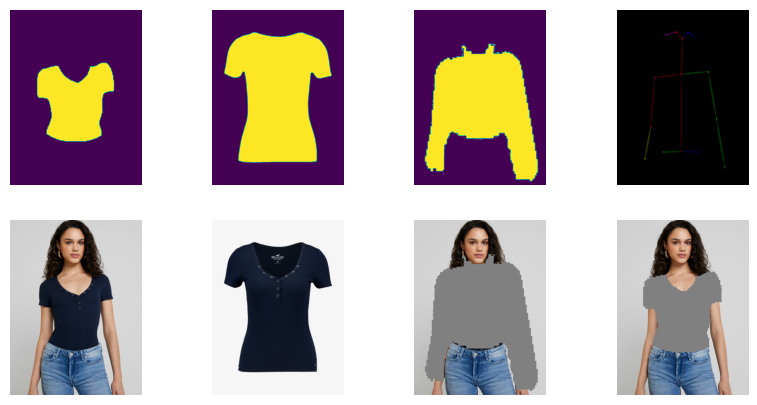

In [24]:
# prompt: get a sample from dataloader

# Lấy một mẫu từ DataLoader
dataiter = iter(val_dataloader)
parse_v3_mask_image, clothing_mask_image, agnostic_mask_image, pose_image = next(dataiter)

# In ra kích thước của batch
print("Kích thước của batch:", len(parse_v3_mask_image))
print("parse_v3_mask_image:", parse_v3_mask_image.shape)
print("clothing_mask_image:", clothing_mask_image.shape)
print("agnostic_mask_image:", agnostic_mask_image.shape)
print("pose_image:", pose_image.shape)

# Hiển thị một vài hình ảnh người
p = 0
plt.figure(figsize=(10, 5))
for i in range(4):
    
    # if i == 0:
    #     break
    
    person_path, clothing_path = dataset.image_pairs[i]
    
    plt.subplot(2, 4, 1)
    plt.imshow(parse_v3_mask_image[i].permute(1, 2, 0))
    plt.axis('off')
    
    plt.subplot(2, 4, 2)
    plt.imshow(clothing_mask_image[i].permute(1, 2, 0))
    plt.axis('off')
    
    plt.subplot(2, 4, 3)
    plt.imshow(agnostic_mask_image[i].permute(1, 2, 0))
    plt.axis('off')
    
    plt.subplot(2, 4, 4)
    plt.imshow(pose_image[i].permute(1, 2, 0))
    plt.axis('off')
    
    person_image = Image.open(f"{dataset.img_dir}/image/{person_path}").convert("RGB")
    plt.subplot(2, 4, 5)
    plt.imshow(person_image)
    plt.axis('off')
    
    cloth_image = Image.open(f"{dataset.img_dir}/cloth/{clothing_path}").convert("RGB")
    plt.subplot(2, 4, 6)
    plt.imshow(cloth_image)
    plt.axis('off')
    
    person_mask_image = np.array(person_image.resize((384, 512)))
    mask = np.array(agnostic_mask_image[i].numpy().squeeze(0)) > 0
    person_mask_image[mask] = [128, 128, 128]
    person_mask_image = Image.fromarray(person_mask_image).convert("RGB")
    plt.subplot(2, 4, 7)
    plt.imshow(person_mask_image)
    plt.axis('off')
    
    person_gt_image = np.array(person_image.resize((384, 512)))
    mask = np.array(parse_v3_mask_image[i].numpy().squeeze(0)) > 0
    person_gt_image[mask] = [128, 128, 128]
    person_gt_image = Image.fromarray(person_gt_image).convert("RGB")
    plt.subplot(2, 4, 8)
    plt.imshow(person_gt_image)
    plt.axis('off')
    
    if i == 5:
        break
    
plt.show()

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class AttentionUNet(nn.Module):
    def __init__(self, in_channels, out_channels, num_channels):
        super(AttentionUNet, self).__init__()
        assert len(num_channels) > 1, "num_channels must have at least 2 elements."

        self.num_channels = num_channels
        self.encoders = nn.ModuleList()
        self.attention_blocks = nn.ModuleList()
        self.decoders = nn.ModuleList()

        # Create encoders
        self.encoders.append(self.conv_block(in_channels, num_channels[0]))
        for i in range(1, len(num_channels) - 1):
            self.encoders.append(self.conv_block(num_channels[i - 1], num_channels[i]))

        # Center block (bottleneck)
        self.center = self.conv_block(num_channels[-2], num_channels[-1])

        # Create attention blocks and decoders
        for i in range(len(num_channels) - 2, -1, -1):
            self.attention_blocks.append(AttentionBlock(F_g=num_channels[i + 1], F_l=num_channels[i], F_int=num_channels[i] // 2))
            self.decoders.append(self.up_conv(num_channels[i + 1] + num_channels[i], num_channels[i]))

        # Final output layer
        self.final = nn.Conv2d(num_channels[0], out_channels, kernel_size=1)
        
        # activate sigmoid
        self.sigmoid = nn.Sigmoid()

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def up_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            self.conv_block(out_channels, out_channels)
        )

    def forward(self, x):
        enc_features = []

        # Encoder path
        for encoder in self.encoders:
            x = encoder(x)
            x = F.max_pool2d(x, 2)
            enc_features.append(x)
            # print("downsample:", x.shape)

        # Center
        x = self.center(x)
        # print("center:", x.shape)

        # Decoder path
        for i in range(len(self.decoders)):
            # print("x", x.shape)
            # print("enc", enc_features[-(i + 1)].shape)
            x = self.decoders[i](torch.cat((self.attention_blocks[i](g=x, x=enc_features[-(i + 1)]), x), dim=1))

        # Final output
        x = self.final(x)
        
        x = self.sigmoid(x)
        
        return x


In [12]:
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [13]:
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os

# Hàm mất mát
def mask_loss(prediction, target):
    return torch.nn.functional.binary_cross_entropy(prediction, target)

def train_loop(config, unet, optimizer, train_dataloader, val_dataloader, lr_scheduler):
    
    early_stopping = EarlyStopping(patience=5, delta=0.001)
    
    # Initialize accelerator and tensorboard logging
    train_loss = []
    val_loss = []
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
        
    device = config.device

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    unet, optimizer, train_dataloader, val_dataloader, lr_scheduler = accelerator.prepare(
        unet, optimizer, train_dataloader, val_dataloader, lr_scheduler
    )

    global_step = 0
    
    print(f"Unet trainable params:", count_trainable_params(unet))

    # Now you train the model
    for epoch in range(config.num_epochs):
        unet.train()
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            parse_v3_mask_image, clothing_mask_image, agnostic_mask_image, pose_image = batch
            
            inputs = torch.cat([clothing_mask_image, agnostic_mask_image, pose_image], dim=1).to(device)
            
            # print(f"inputs shape:", inputs.shape)
                
            with accelerator.accumulate(unet):
                mask_pred = unet(inputs)
                loss = mask_loss(mask_pred.float(), parse_v3_mask_image.float())
                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            train_loss.append(loss.detach().item())
            # print(f"step: {global_step}, loss: {loss.detach().item()}")
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1
        
        if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
            val = []
            for step, batch in enumerate(val_dataloader):
                parse_v3_mask_image, clothing_mask_image, agnostic_mask_image, pose_image = batch
                
                with torch.no_grad():
                    inputs = torch.cat([clothing_mask_image, agnostic_mask_image, pose_image], dim=1).to(device)
                    mask_pred = unet(inputs)
                    iou = iou_score(mask_pred > 0.5, parse_v3_mask_image)
                    val.append(iou)
            __val_loss = np.mean(val)
            val_loss.append(__val_loss)
            progress_bar.set_postfix({"Val_iou": __val_loss})
            
            early_stopping(__val_loss, unet)
            
            if early_stopping.early_stop:
                print("early stopping")
                break
    
    torch.save(unet.state_dict(), os.path.join(config.output_dir, "mask2"))
    print("save model state dict")
    
    with open(os.path.join(config.output_dir, "train_loss.json"), 'w') as f:
        json.dump(train_loss, f, indent=4) 
    print("save train loss")
    
    with open(os.path.join(config.output_dir, "val_iou.json"), 'w') as f:
        json.dump(val_loss, f, indent=4) 
    print("save val IOU")

/home/jupyter/hungbd/viton_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
from diffusers.optimization import get_cosine_schedule_with_warmup

unet = AttentionUNet(in_channels=5, out_channels=1, num_channels=[128, 128, 256, 256, 512, 512])

unet.load_state_dict(torch.load("mask_checkpoint/version4/mask3", weights_only=True))

unet.to(config.device)

optimizer = torch.optim.AdamW(unet.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(dataloader) * config.num_epochs),
)

In [17]:
# args = (config, unet, optimizer, dataloader, val_dataloader, lr_scheduler)

# train_loop(*args)

In [18]:
#------------------------------

In [19]:
parse_v3_mask_image, clothing_mask_image, agnostic_mask_image, pose_image = None, None, None, None
mask_pred = None
for step, batch in enumerate(val_dataloader):
    device = config.device
    parse_v3_mask_image, clothing_mask_image, agnostic_mask_image, pose_image = batch

    with torch.no_grad():
        inputs = torch.cat([clothing_mask_image, agnostic_mask_image, pose_image], dim=1).to(device)
        mask_pred = unet(inputs)
        # iou = iou_score(mask_pred > 0.5, parse_v3_mask_image)
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8352941].


Kích thước của batch: 4
parse_v3_mask_image: torch.Size([4, 1, 512, 384])
clothing_mask_image: torch.Size([4, 1, 512, 384])
agnostic_mask_image: torch.Size([4, 1, 512, 384])
pose_image: torch.Size([4, 3, 512, 384])
IOT: 0.0


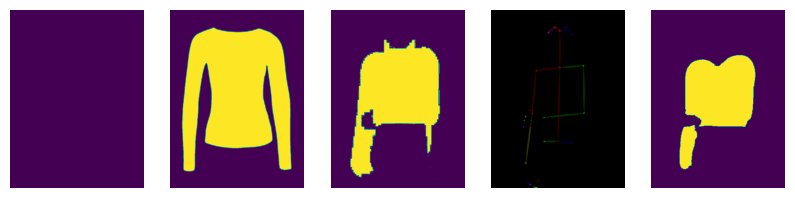

In [20]:
# prompt: get a sample from dataloader

# In ra kích thước của batch
print("Kích thước của batch:", len(parse_v3_mask_image))
print("parse_v3_mask_image:", parse_v3_mask_image.shape)
print("clothing_mask_image:", clothing_mask_image.shape)
print("agnostic_mask_image:", agnostic_mask_image.shape)
print("pose_image:", pose_image.shape)

# Hiển thị một vài hình ảnh người
plt.figure(figsize=(10, 5))
for i in range(1):
    plt.subplot(1, 5, 1)
    plt.imshow(parse_v3_mask_image[i].permute(1, 2, 0))
    plt.axis('off')
    
    plt.subplot(1, 5, 2)
    plt.imshow(clothing_mask_image[i].permute(1, 2, 0))
    plt.axis('off')
    
    plt.subplot(1, 5, 3)
    plt.imshow(agnostic_mask_image[i].permute(1, 2, 0))
    plt.axis('off')
    
    plt.subplot(1, 5, 4)
    plt.imshow(pose_image[i].permute(1, 2, 0))
    plt.axis('off')
    
    plt.subplot(1, 5, 5)
    plt.imshow(mask_pred[i].permute(1, 2, 0).cpu().numpy() > 0.5)
    plt.axis('off')
iou = iou_score(mask_pred[:1].cpu(), parse_v3_mask_image[:1].cpu())
print("IOT:", iou)
plt.show()

In [24]:
import matplotlib.image
def predict(unet, dataset_folder_path, person_img_name, cloth_img_name, device="cpu"):
        #target
        # parse_v3_mask_image = Image.open(f"{self.sub_dir}/image_parse_v3_binary/{clothing_path}").convert("L")
        #input
        clothing_mask_image = Image.open(f"{dataset_folder_path}/cloth_mask/{cloth_img_name}").convert("RGB")
        
        agnostic_image = Image.open(f"{dataset_folder_path}/agnostic-v3.2/{person_img_name}").convert("RGB")
        agnostic_mask_image = np.where(np.all(np.array(agnostic_image) == [128, 128, 128], axis=-1), 1, 0).astype(np.uint8)
        # agnostic_mask_image = Image.fromarray(agnostic_mask_image).convert("RGB")
        matplotlib.image.imsave("temp.jpg", agnostic_mask_image, cmap='gray')
        agnostic_mask_image = Image.open(f"temp.jpg").convert("RGB")
        
        # image_parse_v3 = Image.open(f"{dataset_folder_path}/image-parse-v3/{person_img_name.replace('jpg', 'png')}").convert("RGB")
        # image_parse_v3_mask_image = np.expand_dims(np.where(np.all(np.array(image_parse_v3) == [254, 85, 0], axis=-1), 1, 0), axis=0).astype(float)
        
        pose_image = Image.open(f"{dataset_folder_path}/openpose_img/{person_img_name.replace('.jpg', '_rendered.png')}").convert("RGB")
        
        # Biến đổi cho ảnh và trích xuất đặc trưng trang phục
        transform_1 = transforms.Compose([
            transforms.Resize(config.image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        ])
        
        transform2 = transforms.Grayscale(num_output_channels=1)
        
        clothing_mask_image = transform2(transform_1(clothing_mask_image))
        agnostic_mask_image = transform2(transform_1(agnostic_mask_image))
        pose_image = transform_1(pose_image)
        
        clothing_mask_image = clothing_mask_image.unsqueeze(0)
        agnostic_mask_image = agnostic_mask_image.unsqueeze(0)
        pose_image = pose_image.unsqueeze(0)
        
        # print(clothing_mask_image.shape)
        # print(agnostic_mask_image.shape)
        # print(pose_image.shape)
        
        unet.to(device)
        
        with torch.no_grad():
            input = torch.cat([clothing_mask_image, agnostic_mask_image, pose_image], dim=1).to(device)
            mask_pred = unet(input)
        
        return {
            "agnostic_mask_binary":  agnostic_mask_image.squeeze(0),
            "clothing_mask_binary": clothing_mask_image.squeeze(0),
            "pose_image": pose_image.squeeze(0),
            "pred_mask": mask_pred.squeeze(0),
            "grouth_truth": Image.open(f"{dataset_folder_path}/image-parse-v3/{person_img_name.replace('jpg', 'png')}").convert("RGB"),
            "person": Image.open(f"{dataset_folder_path}/image/{person_img_name}").convert("RGB"),
            "cloth": Image.open(f"{dataset_folder_path}/cloth/{cloth_img_name}").convert("RGB"),
        }

In [25]:
annotations_file = os.path.join(DATASET_DIR, "test_pairs.txt")
# annotations_file = os.path.join(".", "VITONHD_test_paired.txt")

dataset_dir = os.path.join(DATASET_DIR, "test")

result = []

with open(annotations_file, 'r') as f:
    image_pairs = [line.strip().split() for line in f.readlines()]

for i in range(len(image_pairs))[:4]:
    person_img_name, cloth_img_name = image_pairs[i]
    # if "01265" not in person_img_name:
    #     continue
    r = predict(unet, dataset_dir, person_img_name, cloth_img_name, device=config.device)
    result.append(r)

torch.Size([512, 384])
parse shape (512, 384)
torch.Size([512, 384])
parse shape (512, 384)


/var/tmp/ipykernel_3328/439311557.py:55: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  final_mask = np.logical_or(pred_mask, image_parse_v3_binary)


torch.Size([512, 384])
parse shape (512, 384)
torch.Size([512, 384])
parse shape (512, 384)


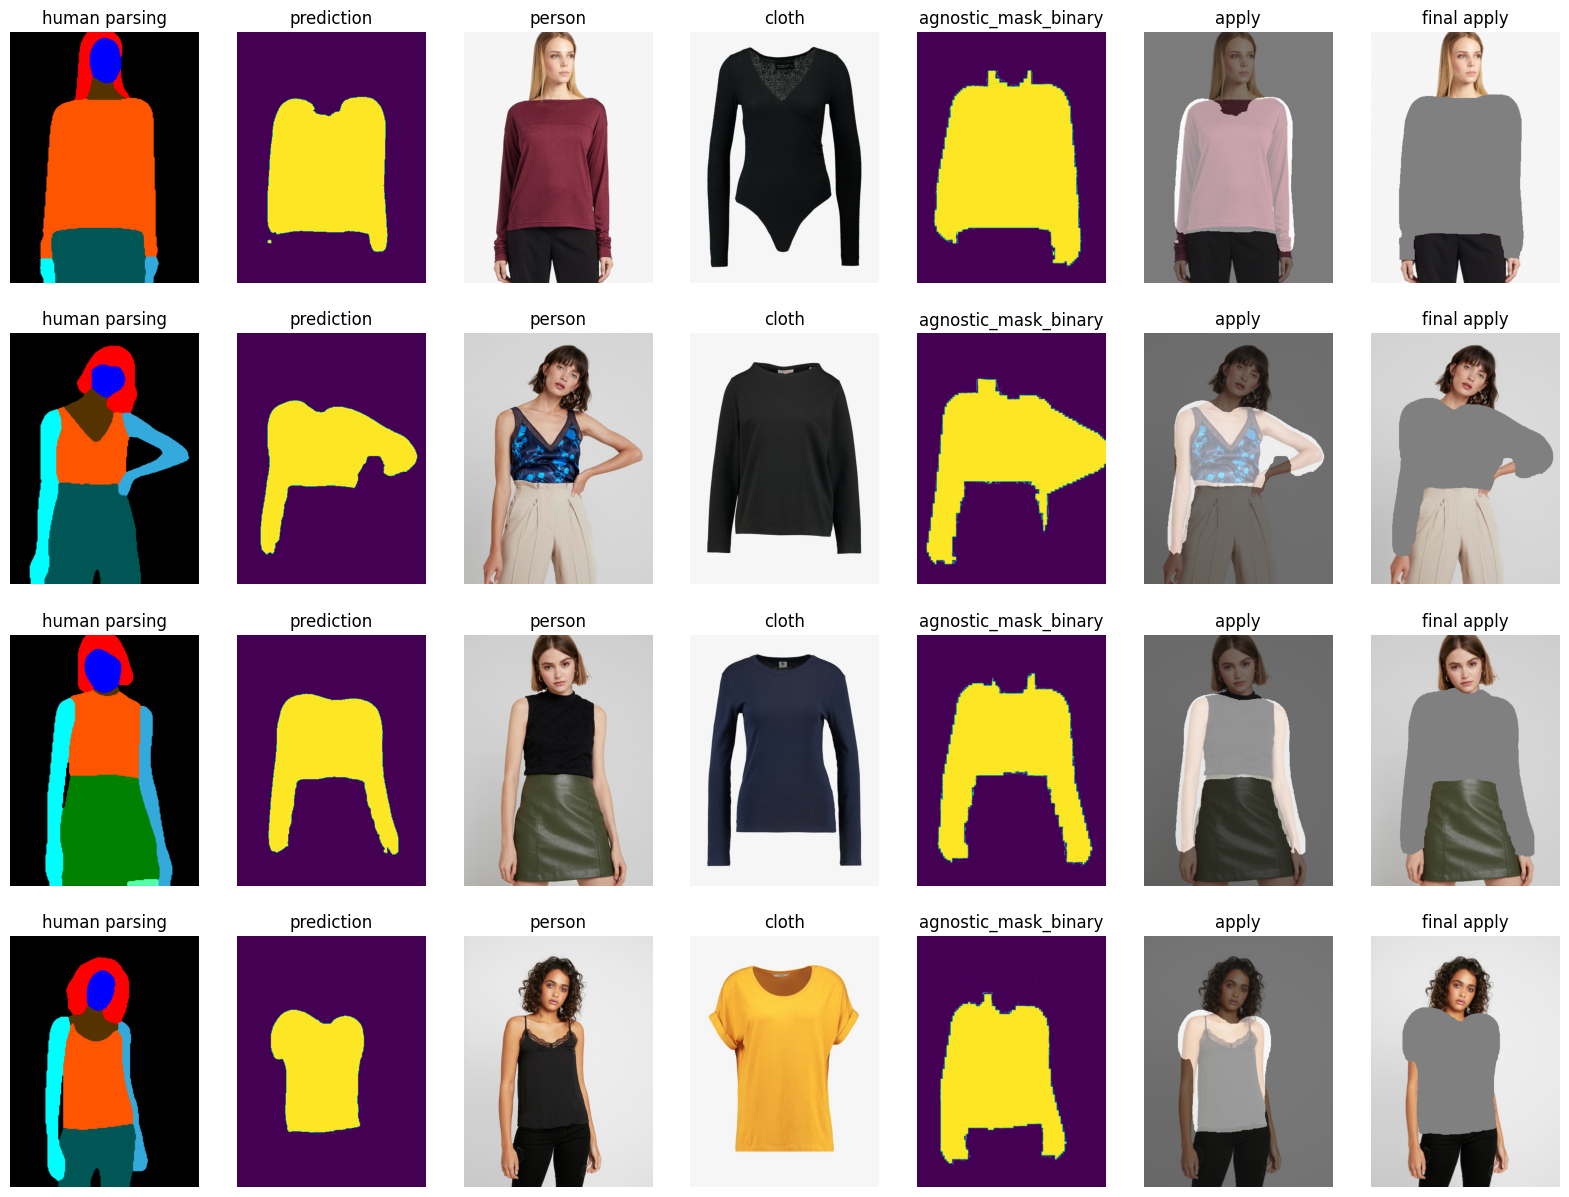

In [26]:
# Hiển thị một vài hình ảnh người
plt.figure(figsize=(20, 15))

p = 1

for i in range(4):

    plt.subplot(4, 7, p)
    plt.imshow(result[i]["grouth_truth"])
    plt.title("human parsing")
    plt.axis('off')

    plt.subplot(4, 7, p + 1)
    plt.imshow(result[i]["pred_mask"].permute(1, 2, 0).cpu() > 0.5)
    plt.title("prediction")
    plt.axis('off')

    plt.subplot(4, 7, p + 2)
    plt.imshow(result[i]["person"])
    plt.title("person")
    plt.axis('off')

    plt.subplot(4, 7, p + 3)
    plt.imshow(result[i]["cloth"])
    plt.title("cloth")
    plt.axis('off')

    plt.subplot(4, 7, p + 4)
    plt.imshow(result[i]["agnostic_mask_binary"].permute(1, 2, 0))
    plt.title("agnostic_mask_binary")
    plt.axis('off')
    
    pred_mask = result[i]["pred_mask"].permute(1, 2, 0).cpu() >= 0.5
    
    person = transforms.Resize(config.image_size)(result[i]["person"])
    
    plt.subplot(4, 7, p + 5)
    plt.imshow(person, alpha=0.9)
    plt.imshow(pred_mask, cmap='gray', alpha=0.5)
    plt.title("apply")
    plt.axis('off')
    
    ground_truth = transforms.Resize(config.image_size)(result[i]["grouth_truth"])
    image_parse_v3_binary = np.where(np.all(np.array(ground_truth) == [254, 85, 0], axis=-1), 1, 0).astype("uint8") == 1
    if image_parse_v3_binary.sum() == 0:
        print(f"{img_dir}/image-parse-v3/{person_path.replace('jpg', 'png')}")
        image_parse_v3_binary = np.where(np.all(np.array(ground_truth) == [0, 0, 85], axis=-1), 1, 0).astype("uint8") == 1
        
    pred_mask = np.squeeze(pred_mask, axis=-1)
    
    print(pred_mask.shape)
    
    print("parse shape", image_parse_v3_binary.shape)
    
    final_mask = np.logical_or(pred_mask, image_parse_v3_binary)
    
#     # Step 1: Resize the image by 1.2 times
#     final_mask = Image.fromarray(final_mask.numpy())
#     new_width = int(384 * 1.1)
#     new_height = int(512 * 1.1)
#     resized_image = final_mask.resize((new_width, new_height))

#     # Step 2: Crop the image to 512x384
#     left = (new_width - 384) // 2
#     top = (new_height - 512) // 2
#     right = left + 384
#     bottom = top + 512
#     final_mask = resized_image.crop((left, top, right, bottom))
    
    padding = 10
    final_mask = binary_dilation(final_mask, structure=np.ones((padding, padding)))
        
    plt.subplot(4, 7, p + 6)
    person = np.array(person)
    person[final_mask == 1] = [128, 128, 128]
    person = Image.fromarray(person)
    plt.imshow(person)
    # plt.imshow(person, alpha=0.5)
    # plt.imshow(final_mask, cmap='gray', alpha=0.5)
    plt.title("final apply")
    plt.axis('off')
    
    p += 7

plt.show()

# Apply for test

## Paired

In [106]:
# annotations_file = os.path.join(DATASET_DIR, "test_pairs.txt")
plt.figure(figsize=(20, 15))
annotations_file = os.path.join(".", "VITONHD_test_paired.txt")

dataset_dir = os.path.join(DATASET_DIR, "test")

result = []

with open(annotations_file, 'r') as f:
    image_pairs = [line.strip().split() for line in f.readlines()]

# j = 1
    
for i in tqdm(range(len(image_pairs))):
    person_img_name, cloth_img_name = image_pairs[i]
    r = predict(unet, dataset_dir, person_img_name, cloth_img_name, device=config.device)
    # pred_mask = r["pred_mask"].permute(1, 2, 0).cpu() >= 0.5
    pred_mask = r["pred_mask"]
    # pred_mask = transforms.Resize((1024, 768))(pred_mask)
    # print(pred_mask)
    pred_mask = pred_mask.permute(1, 2, 0).cpu() >= 0.5
    
    ground_truth = transforms.Resize((config.image_size))(r["grouth_truth"])
    image_parse_v3_binary = np.where(np.all(
        (np.array(ground_truth) == [254, 85, 0]) | 
        (np.array(ground_truth) == [0, 119, 220]), axis=-1), 1, 0).astype("uint8") == 1
    if image_parse_v3_binary.sum() == 0:
        image_parse_v3_binary = np.where(np.all(np.array(ground_truth) == [0, 0, 85], axis=-1), 1, 0).astype("uint8") == 1
    
    pred_mask = np.squeeze(pred_mask, axis=-1).numpy()
    
    final_mask = np.logical_or(pred_mask, image_parse_v3_binary)

    #####
    padding = 10
    
    final_mask = binary_dilation(final_mask, structure=np.ones((padding, padding)))
    #####
    
#     #####
#     # Step 1: Resize the image by 1.2 times
#     final_mask = Image.fromarray(final_mask)
#     new_width = int(384 * 1.1)
#     new_height = int(512 * 1.1)
#     resized_image = final_mask.resize((new_width, new_height))

#     # Step 2: Crop the image to 512x384
#     left = (new_width - 384) // 2
#     top = (new_height - 512) // 2
#     right = left + 384
#     bottom = top + 512
    
#     final_mask = resized_image.crop((left, top, right, bottom))
    
#     final_mask = transforms.Resize((1024, 768), interpolation=transforms.InterpolationMode.NEAREST)(final_mask)
    
#     final_mask = np.array(final_mask)
#     #####
    
    final_mask_image = Image.fromarray(final_mask).convert("RGB")
    
    final_mask_image = transforms.Resize((1024, 768), interpolation=transforms.InterpolationMode.NEAREST)(final_mask_image)
    
    final_mask_image.save(os.path.join(dataset_dir, "agnostic-mask-paired-v3.5", person_img_name))
    
    # person = Image.open(f"{dataset_dir}/image/{person_img_name}").convert("RGB")
    # plt.subplot(2, 4, j)
    # plt.imshow(person)
    # plt.title("person")
    # plt.axis('off')
    
#     pixels = np.array(person)
#     pixels[final_mask] = [128, 128, 128]
#     # print(pixels)
#     mask_person = Image.fromarray(pixels)
    
    
#     mask_person.save(os.path.join(dataset_dir, "agnostic-v3.3", person_img_name))
    # plt.subplot(2, 4, j + 1)
    # plt.imshow(mask_person)
    # plt.title("mask person")
    # plt.axis('off')
    
#     j += 1
    
#     if j == 10:
#         break
    
# plt.show()

100%|██████████| 2032/2032 [06:09<00:00,  5.49it/s]


<Figure size 2000x1500 with 0 Axes>

## Unpaired

In [104]:
annotations_file = os.path.join(DATASET_DIR, "test_pairs.txt")
plt.figure(figsize=(20, 15))
# annotations_file = os.path.join(".", "VITONHD_test_paired.txt")

dataset_dir = os.path.join(DATASET_DIR, "test")

result = []

with open(annotations_file, 'r') as f:
    image_pairs = [line.strip().split() for line in f.readlines()]

# j = 1
    
for i in tqdm(range(len(image_pairs))):
    person_img_name, cloth_img_name = image_pairs[i]
    r = predict(unet, dataset_dir, person_img_name, cloth_img_name, device=config.device)
    # pred_mask = r["pred_mask"].permute(1, 2, 0).cpu() >= 0.5
    pred_mask = r["pred_mask"]
    # pred_mask = transforms.Resize((1024, 768))(pred_mask)
    # print(pred_mask)
    pred_mask = pred_mask.permute(1, 2, 0).cpu() >= 0.5
    
    ground_truth = transforms.Resize((config.image_size))(r["grouth_truth"])
    image_parse_v3_binary = np.where(np.all(
        (np.array(ground_truth) == [254, 85, 0]) | 
        (np.array(ground_truth) == [0, 119, 220]), axis=-1), 1, 0).astype("uint8") == 1
    if image_parse_v3_binary.sum() == 0:
        image_parse_v3_binary = np.where(np.all(np.array(ground_truth) == [0, 0, 85], axis=-1), 1, 0).astype("uint8") == 1
    
    pred_mask = np.squeeze(pred_mask, axis=-1).numpy()
    
    final_mask = np.logical_or(pred_mask, image_parse_v3_binary)

    #####
    padding = 10
    
    final_mask = binary_dilation(final_mask, structure=np.ones((padding, padding)))
    #####
    
#     #####
#     # Step 1: Resize the image by 1.2 times
#     final_mask = Image.fromarray(final_mask)
#     new_width = int(384 * 1.1)
#     new_height = int(512 * 1.1)
#     resized_image = final_mask.resize((new_width, new_height))

#     # Step 2: Crop the image to 512x384
#     left = (new_width - 384) // 2
#     top = (new_height - 512) // 2
#     right = left + 384
#     bottom = top + 512
    
#     final_mask = resized_image.crop((left, top, right, bottom))
    
#     final_mask = transforms.Resize((1024, 768), interpolation=transforms.InterpolationMode.NEAREST)(final_mask)
    
#     final_mask = np.array(final_mask)
#     #####
    
    final_mask_image = Image.fromarray(final_mask).convert("RGB")
    
    final_mask_image = transforms.Resize((1024, 768), interpolation=transforms.InterpolationMode.NEAREST)(final_mask_image)
    
    final_mask_image.save(os.path.join(dataset_dir, "agnostic-mask-unpaired-v3.5", person_img_name))
    
    # person = Image.open(f"{dataset_dir}/image/{person_img_name}").convert("RGB")
    # plt.subplot(2, 4, j)
    # plt.imshow(person)
    # plt.title("person")
    # plt.axis('off')
    
#     pixels = np.array(person)
#     pixels[final_mask] = [128, 128, 128]
#     # print(pixels)
#     mask_person = Image.fromarray(pixels)
    
    
#     mask_person.save(os.path.join(dataset_dir, "agnostic-v3.3", person_img_name))
    # plt.subplot(2, 4, j + 1)
    # plt.imshow(mask_person)
    # plt.title("mask person")
    # plt.axis('off')
    
#     j += 1
    
#     if j == 10:
#         break
    
# plt.show()

100%|██████████| 2032/2032 [06:10<00:00,  5.48it/s]


<Figure size 2000x1500 with 0 Axes>

# Test evaluation

In [30]:
# annotations_file = os.path.join(DATASET_DIR, "test_pairs.txt")
annotations_file = os.path.join(".", "VITONHD_test_paired.txt")

dataset_dir = os.path.join(DATASET_DIR, "test")

result_iou = []
result = []

with open(annotations_file, 'r') as f:
    image_pairs = [line.strip().split() for line in f.readlines()]

for i in tqdm(range(len(image_pairs))[:8]):
    person_img_name, cloth_img_name = image_pairs[i]
    r = predict(unet, dataset_dir, person_img_name, cloth_img_name, device=config.device)

    ground_truth_image = r["grouth_truth"].resize((384, 512))
    ground_truth = np.where(np.all(np.array(ground_truth_image) == [254, 85, 0], axis=-1), 1, 0).astype("uint8")
    if ground_truth.sum() == 0:
        print(person_img_name)
        ground_truth = np.where(np.all(np.array(ground_truth_image) == [0, 0, 85], axis=-1), 1, 0).astype("uint8")
    
    prediction = r["pred_mask"].cpu() > 0.5
    ground_truth = torch.from_numpy(ground_truth).unsqueeze(0).unsqueeze(0)
    prediction = prediction.unsqueeze(0)
    print(ground_truth.shape, prediction.shape)
    iou = iou_score(prediction, ground_truth)
    result.append(r)
    result_iou.append(iou)

 12%|█▎        | 1/8 [00:00<00:01,  6.13it/s]

torch.Size([1, 1, 512, 384]) torch.Size([1, 1, 512, 384])


 25%|██▌       | 2/8 [00:00<00:01,  5.02it/s]

torch.Size([1, 1, 512, 384]) torch.Size([1, 1, 512, 384])


 38%|███▊      | 3/8 [00:00<00:01,  4.71it/s]

torch.Size([1, 1, 512, 384]) torch.Size([1, 1, 512, 384])


 62%|██████▎   | 5/8 [00:01<00:00,  4.83it/s]

torch.Size([1, 1, 512, 384]) torch.Size([1, 1, 512, 384])
torch.Size([1, 1, 512, 384]) torch.Size([1, 1, 512, 384])


 75%|███████▌  | 6/8 [00:01<00:00,  4.66it/s]

torch.Size([1, 1, 512, 384]) torch.Size([1, 1, 512, 384])


 88%|████████▊ | 7/8 [00:01<00:00,  4.49it/s]

torch.Size([1, 1, 512, 384]) torch.Size([1, 1, 512, 384])


100%|██████████| 8/8 [00:01<00:00,  4.63it/s]

torch.Size([1, 1, 512, 384]) torch.Size([1, 1, 512, 384])


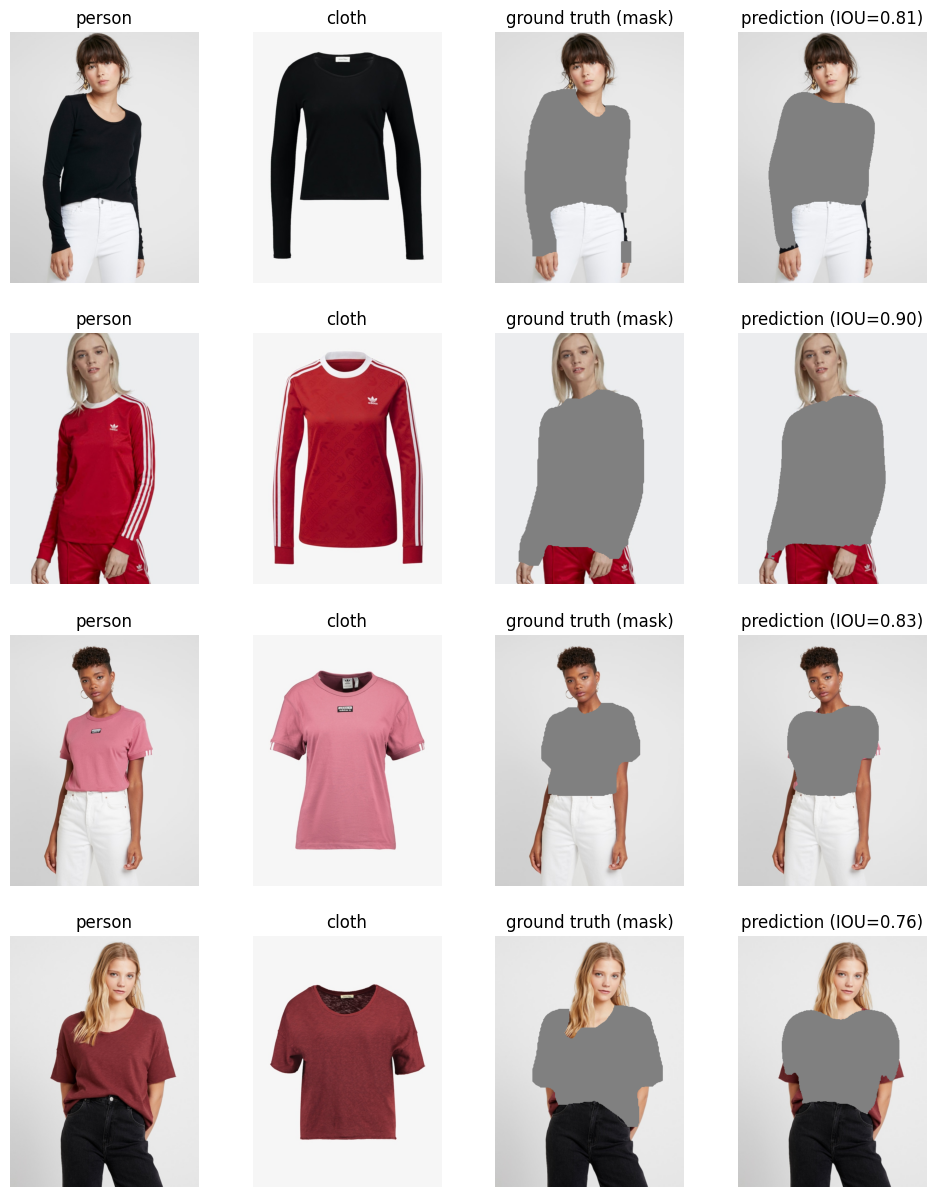

In [54]:
# Hiển thị một vài hình ảnh người
plt.figure(figsize=(12, 15))

p = 1

for i in range(4):
    # plt.text(0, 0, s=f"IOT: {result_iou[i]}")
    plt.subplot(4, 4, p)
    plt.imshow(result[i]["person"])
    plt.title("person")
    plt.axis('off')

    plt.subplot(4, 4, p + 1)
    plt.imshow(result[i]["cloth"])
    plt.title("cloth")
    plt.axis('off')
    
    groung_truth = result[i]['grouth_truth'].resize((384, 512))
    image_parse_v3_binary = np.where(np.all(
        (np.array(groung_truth) == [254, 85, 0]) | 
        (np.array(groung_truth) == [0, 119, 220]), axis=-1), 1, 0).astype("uint8") == 1
    if image_parse_v3_binary.sum() == 0:
        image_parse_v3_binary = np.where(np.all(np.array(groung_truth) == [0, 0, 85], axis=-1), 1, 0).astype("uint8") == 1
    padding = 20
    image_parse_v3_binary = binary_dilation(image_parse_v3_binary, structure=np.ones((padding, padding)))
    
    person = np.array(result[i]["person"].resize((384, 512)))
    person[image_parse_v3_binary == 1] = [128, 128, 128]
    
    plt.subplot(4, 4, p + 2)
    plt.imshow(person)
    plt.title("ground truth (mask)")
    plt.axis('off')

    pred_mask = result[i]["pred_mask"].permute(1, 2, 0).cpu() > 0.5
    pred_mask = np.squeeze(pred_mask, axis=-1)
    person = np.array(result[i]["person"].resize((384, 512)))
    person[pred_mask == 1] = [128, 128, 128]
    plt.subplot(4, 4, p + 3)
    plt.imshow(person)
    plt.title(f"prediction (IOU={result_iou[i]:.2f})")
    plt.axis('off')
    
    p += 4

plt.savefig("temp.png")
plt.show()


In [86]:
np.mean(result)

np.float64(0.8242088981324583)